
        CANCER METASTASIS PREDICTION MODEL        

Data Preprocessing...
Removing potential leakage columns: ['Adrenal Metastasis', 'Bone Metastasis', 'Bowel Metastasis', 'Brain Metastasis', 'Genito Urinary Metastasis', 'Hepatobilary Metastasis', 'Leptomeninges Metastasis', 'Liver Metastasis', 'Localrecurrence Metastasis', 'Lung Metastasis', 'Lymph Node Metastasis', 'Metastatic Site', 'Ovary Metastasis', 'Pelvicwall Floor Metastasis', 'Pericardium Metastasis', 'Peritoneum Metastasis', 'Pleura Metastasis', 'Skin Metastasis', 'Soft Tissue Metastasis', 'Spleen Metastasis', 'Stomach Esopagus Metastasis', 'Symptomatic Metastasis', 'Trachea Metastasis']

Dataset Shape: (902, 67)
Target Distribution:
Metastatic/Non-Metastatic
Metastatic        514
Non-Metastatic    387
Name: count, dtype: int64

Metastatic Rate: 57.05%


--- Exploratory Data Analysis ---


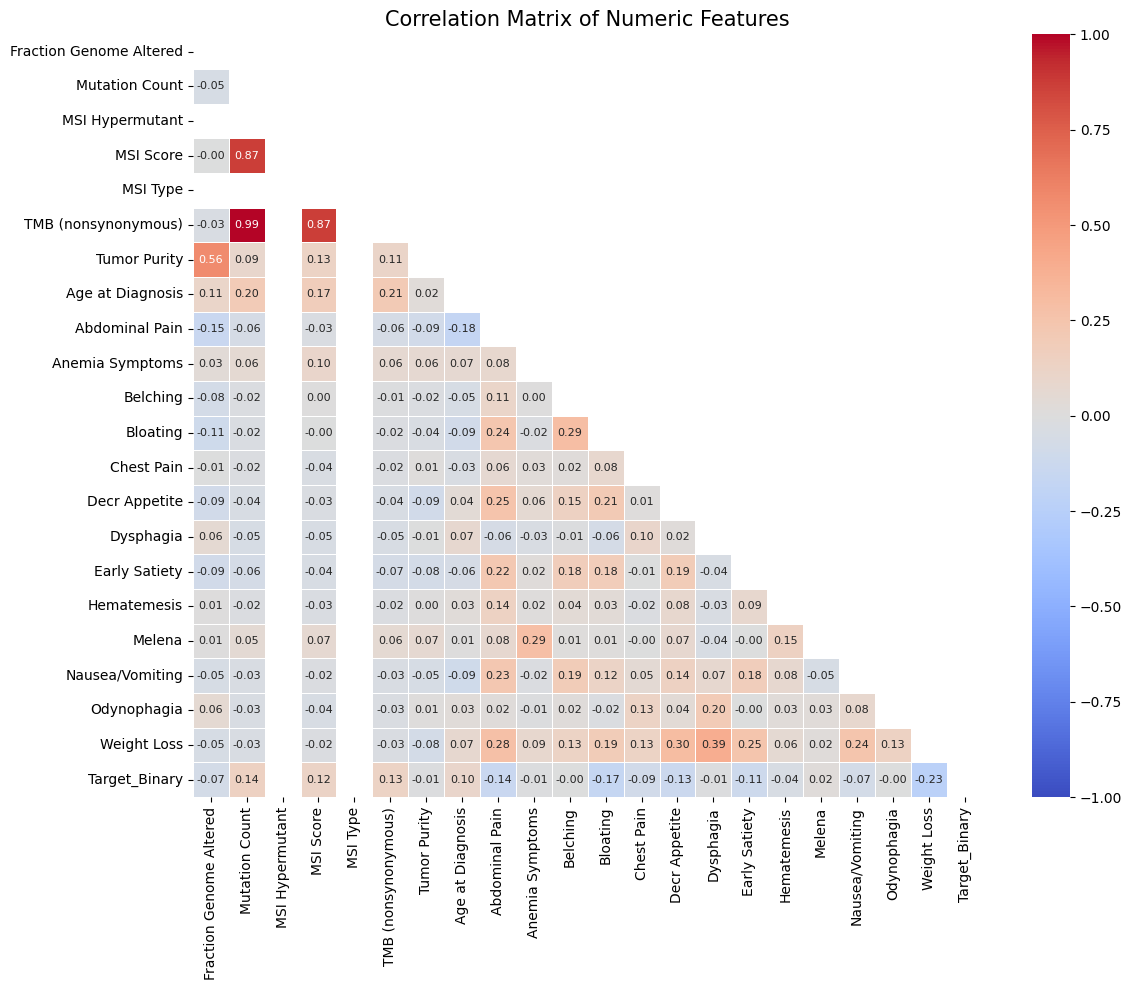

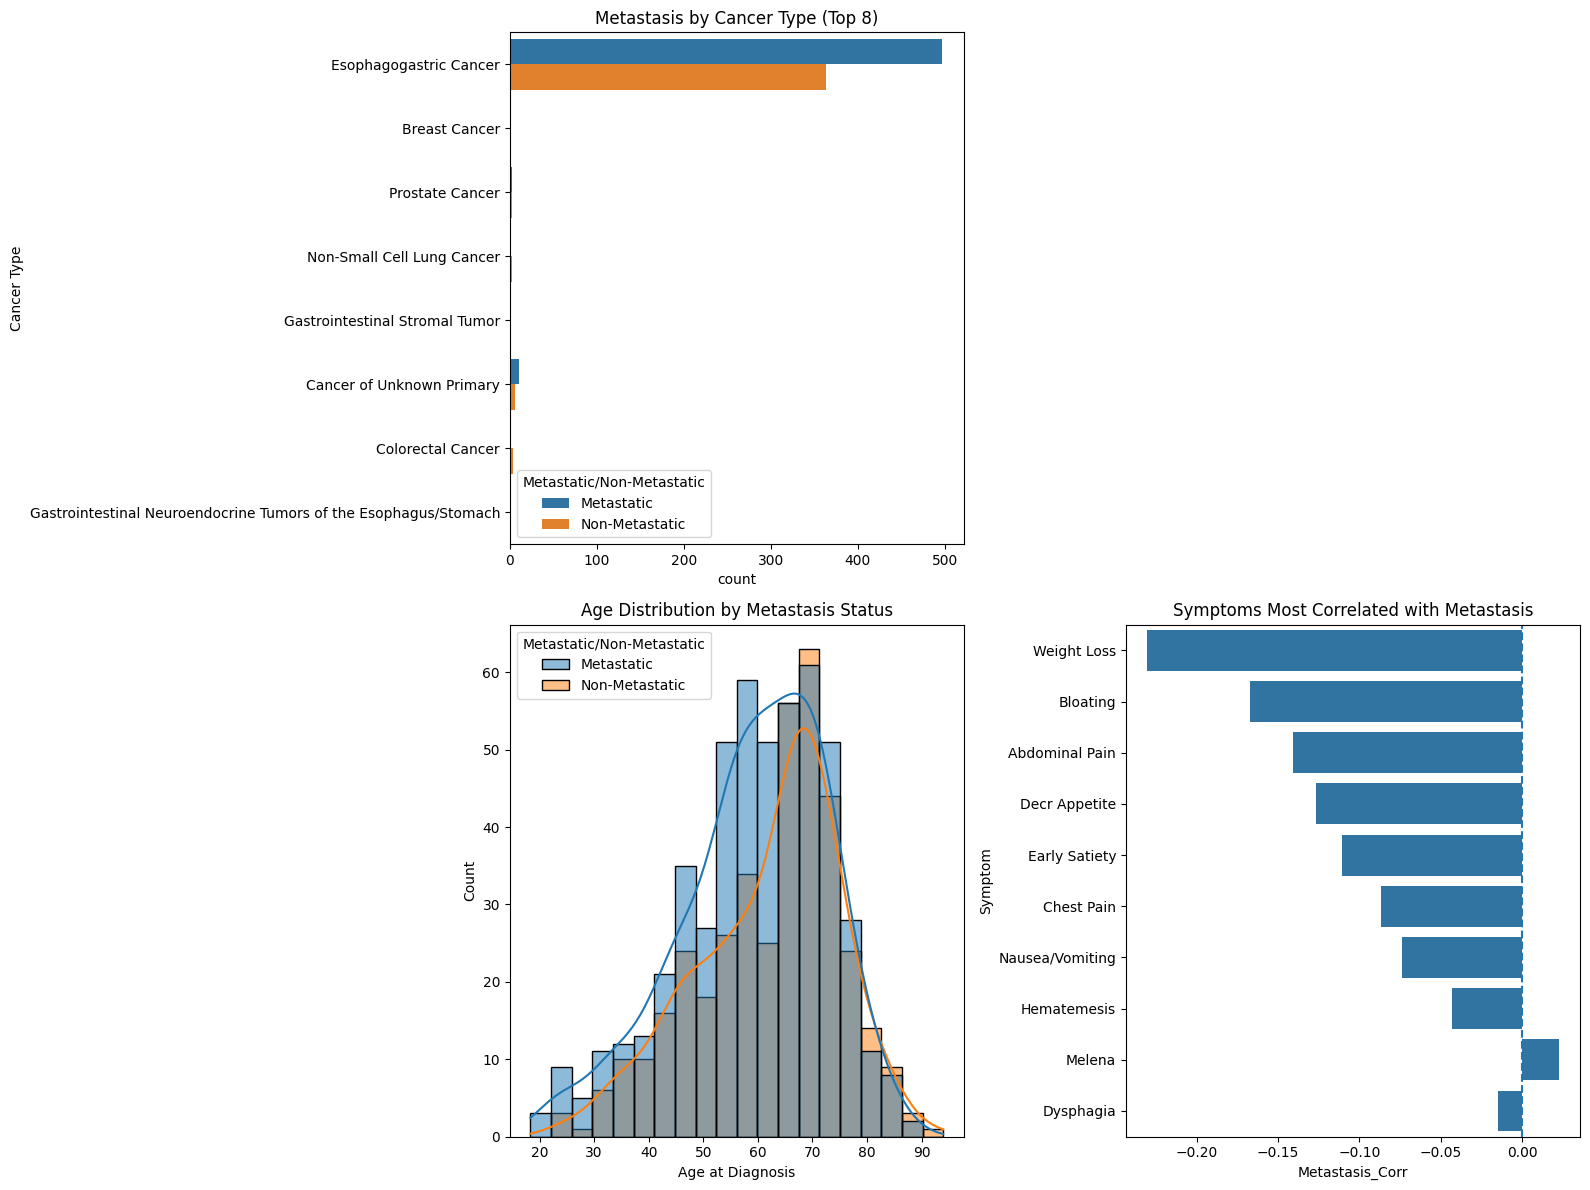

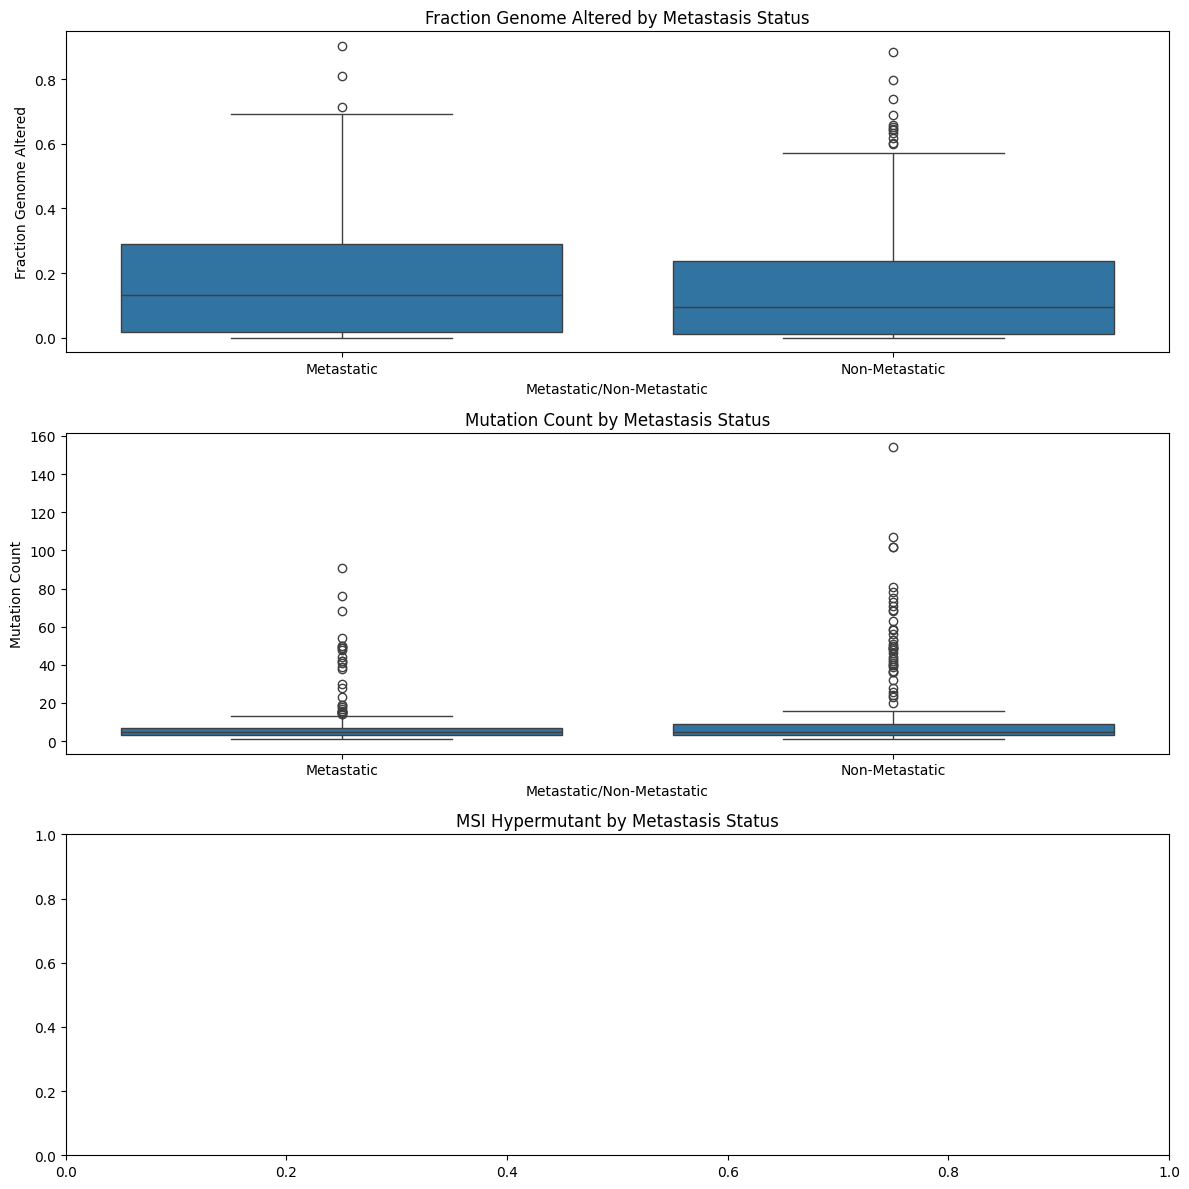



--- Feature Engineering and Selection ---
Keeping 26/28 features
Numeric: 19, Categorical: 7


--- Modeling ---
Falling back to standard train-test split
Train: 676 samples, Test: 226 samples

Training and evaluating models...

Training Logistic Regression...
Accuracy: 0.6283
                precision    recall  f1-score   support

    Metastatic       0.68      0.69      0.69       134
Non-Metastatic       0.54      0.53      0.54        92

      accuracy                           0.63       226
     macro avg       0.61      0.61      0.61       226
  weighted avg       0.63      0.63      0.63       226


Training Random Forest...
Accuracy: 0.6150
                precision    recall  f1-score   support

    Metastatic       0.67      0.70      0.68       134
Non-Metastatic       0.53      0.49      0.51        92

      accuracy                           0.62       226
     macro avg       0.60      0.60      0.60       226
  weighted avg       0.61      0.62      0.61       226


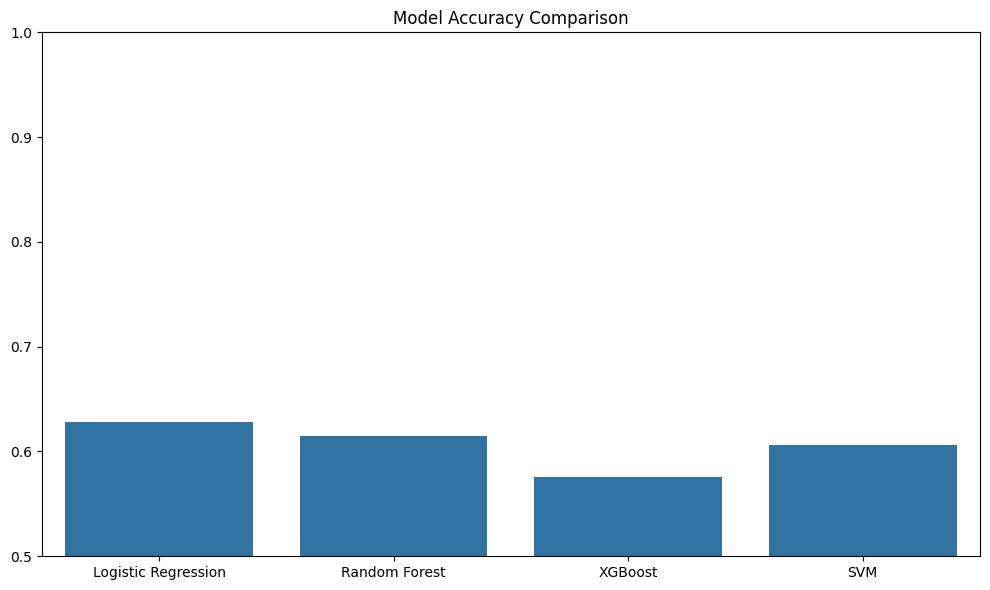

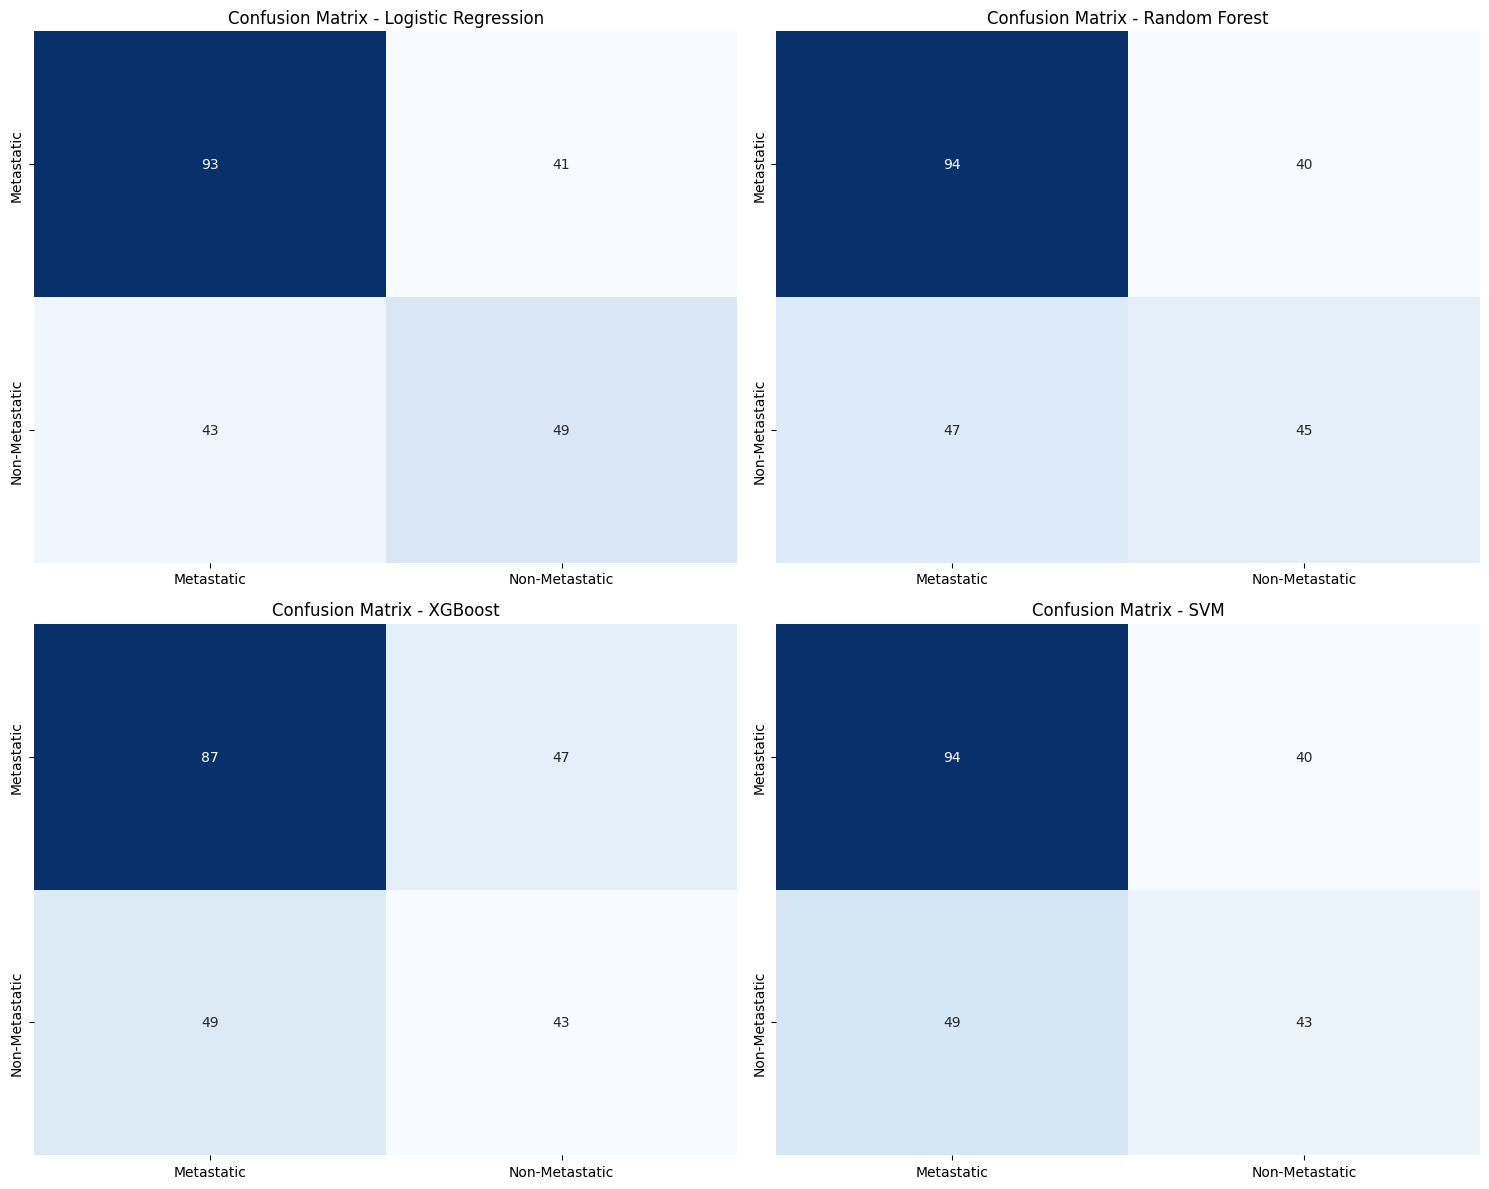

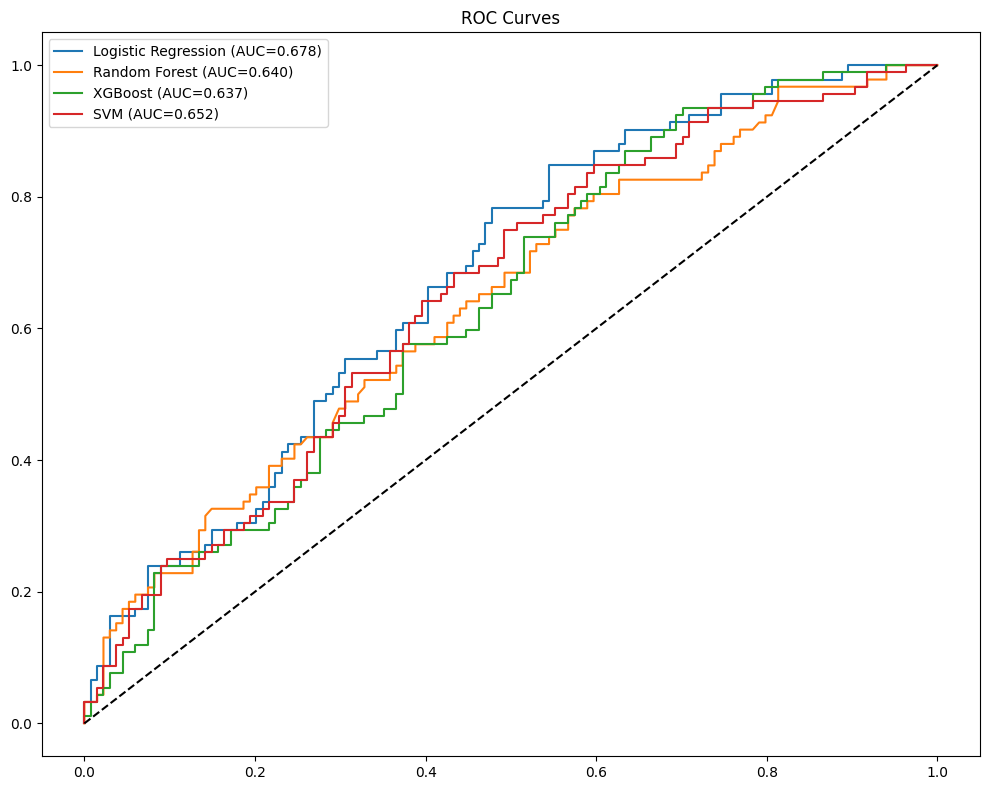

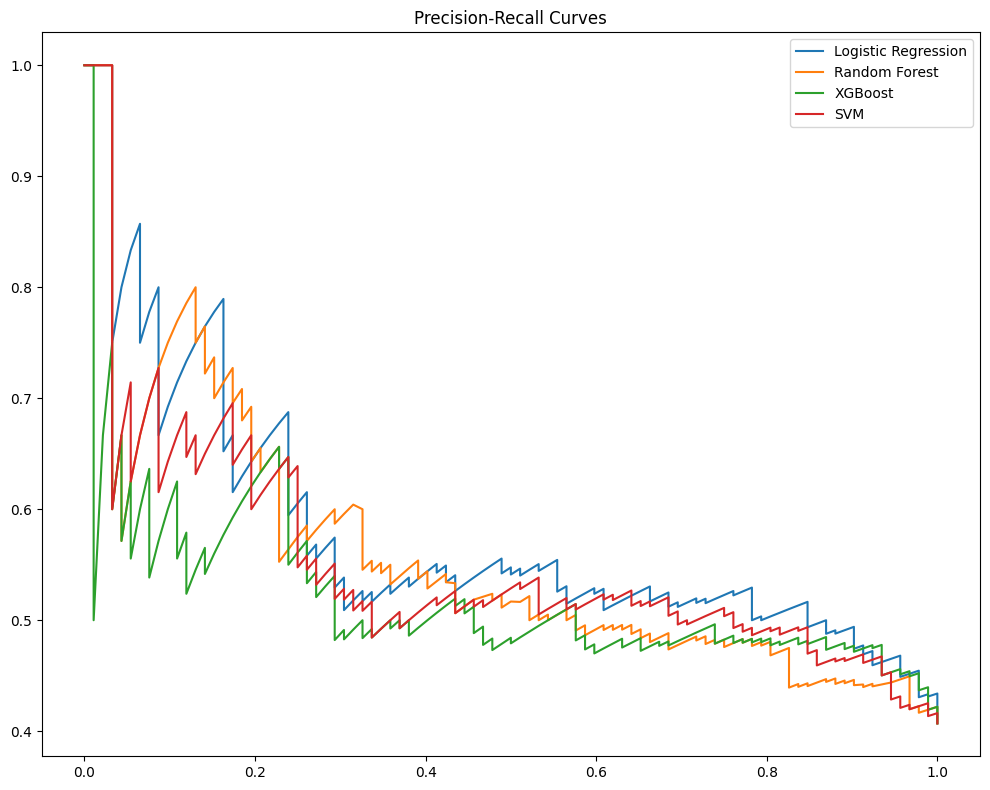



--- Feature Group Analysis ---

Evaluating Genomic Only...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy (CV): 0.5964 ± 0.0219
Accuracy (Test): 0.6150

Evaluating Symptoms Only...
Accuracy (CV): 0.5554 ± 0.0374
Accuracy (Test): 0.5708

Evaluating Clinical Only...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy (CV): 0.5765 ± 0.0355
Accuracy (Test): 0.5575

Evaluating Genomic + Clinical...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy (CV): 0.6031 ± 0.0285
Accuracy (Test): 0.5752

Evaluating Genomic + Symptoms...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy (CV): 0.6264 ± 0.0403
Accuracy (Test): 0.6239

Evaluating Clinical + Symptoms...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy (CV): 0.6231 ± 0.0256
Accuracy (Test): 0.6416

Evaluating All Features...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy (CV): 0.6353 ± 0.0375
Accuracy (Test): 0.6283


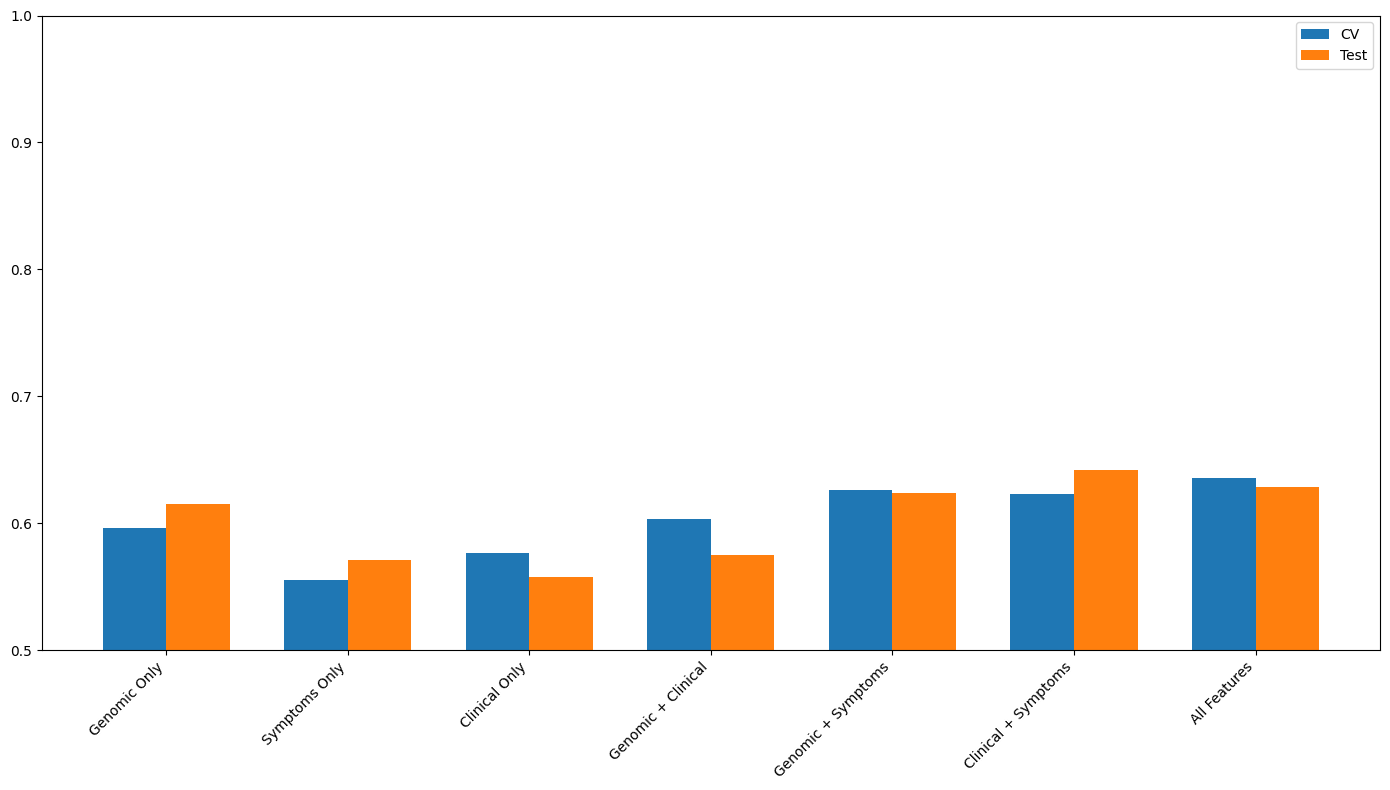



--- Summary ---
Logistic Regression: 0.6283
Random Forest: 0.6150
XGBoost: 0.5752
SVM: 0.6062

Best Model: Logistic Regression (0.6283)
Best Feature Group: Clinical + Symptoms (0.6416)

Conclusion: Use Logistic Regression with clinical + symptoms features.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                            roc_curve, auc, precision_recall_curve)
from sklearn.base import clone

df = pd.read_csv('Cancer data - IMP.csv')

print(f"\n{'='*50}")
print(f"{'CANCER METASTASIS PREDICTION MODEL':^50}")
print(f"{'='*50}\n")

if 'Metastatic/Non-Metastatic' not in df.columns:
    print("Target column 'Metastatic/Non-Metastatic' not found. Creating it based on metastasis data...")
    metastasis_cols = [col for col in df.columns if 'Metastasis' in col]
    for col in metastasis_cols:
        if df[col].dtype == 'object':
            df[col] = df[col].str.lower().map({'yes': 1, 'no': 0}).fillna(0).astype(int)
    df['Metastatic/Non-Metastatic'] = df[metastasis_cols].sum(axis=1).apply(lambda x: 'Metastatic' if x > 0 else 'Non-Metastatic')
genomic_features = [
    'Fraction Genome Altered', 'Mutation Count', 'MSI Hypermutant',
    'MSI Score', 'MSI Type', 'TMB (nonsynonymous)', 'Tumor Purity'
]

symptom_features = [
    'Abdominal Pain', 'Anemia Symptoms', 'Belching', 'Bloating',
    'Chest Pain', 'Decr Appetite', 'Dysphagia', 'Early Satiety',
    'Hematemesis', 'Melena', 'Nausea/Vomiting', 'Odynophagia', 'Weight Loss'
]

clinical_features = [
    'Age at Diagnosis', 'Sex', 'BMI Categories', 'Cancer Type',
    'Histology', 'Oncotree Code', 'Primary Tumor Site', 'ECOG performance status'
]

print("Data Preprocessing...")
for col in symptom_features:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].str.lower().map({'yes': 1, 'no': 0}).fillna(0).astype(int)

for col in genomic_features:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='coerce')

if 'MSI Type' in df.columns and df['MSI Type'].dtype == 'object':
    msi_map = {'MSS': 0, 'MSI-L': 1, 'MSI-H': 2}
    df['MSI Type'] = df['MSI Type'].map(msi_map).fillna(0)

if 'Age at Diagnosis' in df.columns:
    df['Age at Diagnosis'] = pd.to_numeric(df['Age at Diagnosis'], errors='coerce')

drop_cols = [col for col in df.columns if 'metasta' in col.lower() and col != 'Metastatic/Non-Metastatic']
if drop_cols:
    print(f"Removing potential leakage columns: {drop_cols}")
    df = df.drop(columns=drop_cols)

target_encoder = LabelEncoder()
y = target_encoder.fit_transform(df['Metastatic/Non-Metastatic'])
class_names = target_encoder.classes_[:2]

print(f"\nDataset Shape: {df.shape}")
print("Target Distribution:")
print(df['Metastatic/Non-Metastatic'].value_counts())
print(f"\nMetastatic Rate: {100 * df['Metastatic/Non-Metastatic'].value_counts(normalize=True)['Metastatic']:.2f}%")

print("\n\n--- Exploratory Data Analysis ---")
numeric_cols = [c for c in genomic_features + ['Age at Diagnosis'] if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
numeric_cols += [c for c in symptom_features if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

df['Target_Binary'] = y
if numeric_cols:
    corr_data = df[numeric_cols + ['Target_Binary']].fillna(df[numeric_cols + ['Target_Binary']].median())
    corr_matrix = corr_data.corr()
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
                vmin=-1, vmax=1, linewidths=0.5, annot_kws={'size': 8})
    plt.title('Correlation Matrix of Numeric Features', fontsize=15)
    plt.tight_layout()
    plt.show()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
if 'Cancer Type' in df.columns:
    top8 = df['Cancer Type'].value_counts().head(8).index
    sns.countplot(y='Cancer Type', hue='Metastatic/Non-Metastatic',
                  data=df[df['Cancer Type'].isin(top8)], ax=axes[0, 0])
    axes[0, 0].set_title('Metastasis by Cancer Type (Top 8)')

# IMPORTANT CHANGE: Skip the Stage plot since we removed it
axes[0, 1].set_visible(False)

if 'Age at Diagnosis' in df.columns:
    sns.histplot(data=df, x='Age at Diagnosis', hue='Metastatic/Non-Metastatic',
                 bins=20, kde=True, ax=axes[1,0])
    axes[1,0].set_title('Age Distribution by Metastasis Status')

symptom_rates = pd.DataFrame({
    'Symptom': symptom_features,
    'Present_Rate': [df[col].mean() if col in df else 0 for col in symptom_features],
    'Metastasis_Corr': [df[col].corr(df['Target_Binary']) if col in df else 0 for col in symptom_features]
}).sort_values('Metastasis_Corr', key=abs, ascending=False).head(10)
sns.barplot(x='Metastasis_Corr', y='Symptom', data=symptom_rates, ax=axes[1,1])
axes[1,1].set_title('Symptoms Most Correlated with Metastasis')
axes[1,1].axvline(0, linestyle='--')
plt.tight_layout()
plt.show()

genomic_numeric = [c for c in genomic_features if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
if genomic_numeric:
    np_plots = min(len(genomic_numeric),3)
    fig, axes = plt.subplots(np_plots,1,figsize=(12,4*np_plots))
    if np_plots==1: axes=[axes]
    for i, feat in enumerate(genomic_numeric[:np_plots]):
        sns.boxplot(x='Metastatic/Non-Metastatic', y=feat,
                    data=df[['Metastatic/Non-Metastatic',feat]].dropna(), ax=axes[i])
        axes[i].set_title(f'{feat} by Metastasis Status')
    plt.tight_layout()
    plt.show()

print("\n\n--- Feature Engineering and Selection ---")
all_features = [f for lst in [genomic_features, symptom_features, clinical_features] for f in lst if f in df.columns]
missing_pct = df[all_features].isna().mean()
valid_features = missing_pct[missing_pct<0.5].index.tolist()
numeric_features = [f for f in valid_features if pd.api.types.is_numeric_dtype(df[f]) or f in genomic_features]
categorical_features = [f for f in valid_features if f not in numeric_features]

print(f"Keeping {len(valid_features)}/{len(all_features)} features")
print(f"Numeric: {len(numeric_features)}, Categorical: {len(categorical_features)}")

print("\n\n--- Modeling ---")
X = df[valid_features]

try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
except ValueError as e:
    print(f"Warning: Could not perform stratified split: {e}")
    print("Falling back to standard train-test split")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f"Train: {X_train.shape[0]} samples, Test: {X_test.shape[0]} samples")

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                               ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                                   ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

models = {
    'Logistic Regression': LogisticRegression(max_iter=2000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=1000, random_state=42),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

results = {}
feature_importances = {}

print("\nTraining and evaluating models...")
for name, model in models.items():
    print(f"\nTraining {name}...")
    pipeline = Pipeline([('preprocessor', preprocessor),
                         ('classifier', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:,1]
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'pipeline': pipeline,
        'accuracy': accuracy,
        'predictions': y_pred,
        'probabilities': y_prob,
        'conf_matrix': confusion_matrix(y_test, y_pred)
    }
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred, target_names=class_names))
    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = model.feature_importances_

print("\n\n--- Model Evaluation ---")
accuracies = [results[n]['accuracy'] for n in models]
plt.figure(figsize=(10,6))
sns.barplot(x=list(models.keys()), y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylim(0.5,1.0)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2,2,figsize=(15,12))
for ax, (name, res) in zip(axes.flatten(), results.items()):
    sns.heatmap(res['conf_matrix'], annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'Confusion Matrix - {name}')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,8))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['probabilities'])
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc(fpr,tpr):.3f})')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curves')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,8))
for name, res in results.items():
    precision, recall, _ = precision_recall_curve(y_test, res['probabilities'])
    plt.plot(recall, precision, label=name)
plt.title('Precision-Recall Curves')
plt.legend()
plt.tight_layout()
plt.show()

if feature_importances:
    best_model_name = max(results, key=lambda x: results[x]['accuracy'])
    if best_model_name in feature_importances:
        print(f"\nFeature Importances for {best_model_name}:")
        best_pipe = results[best_model_name]['pipeline']
        pre = best_pipe.named_steps['preprocessor']
        num_feats = numeric_features
        cat_feats = pre.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
        feat_names = list(num_feats) + list(cat_feats)
        imp = feature_importances[best_model_name]
        if len(imp) == len(feat_names):
            imp_df = pd.DataFrame({'Feature':feat_names,'Importance':imp})\
                        .sort_values('Importance', ascending=False).head(20)
            plt.figure(figsize=(12,10))
            sns.barplot(x='Importance', y='Feature', data=imp_df)
            plt.title(f'Top 20 Importances ({best_model_name})')
            plt.tight_layout()
            plt.show()

print("\n\n--- Feature Group Analysis ---")
feature_groups = {
    'Genomic Only': [f for f in genomic_features if f in valid_features],
    'Symptoms Only': [f for f in symptom_features if f in valid_features],
    'Clinical Only': [f for f in clinical_features if f in valid_features],
    'Genomic + Clinical': [f for f in genomic_features + clinical_features if f in valid_features],
    'Genomic + Symptoms': [f for f in genomic_features + symptom_features if f in valid_features],
    'Clinical + Symptoms': [f for f in clinical_features + symptom_features if f in valid_features],
    'All Features': valid_features
}

group_performances = {}

best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_clf = results[best_model_name]['pipeline'].named_steps['classifier']

for group_name, features in feature_groups.items():
    print(f"\nEvaluating {group_name}...")
    if not features:
        print("No valid features, skipping.")
        continue
    grp_num = [f for f in features if f in numeric_features]
    grp_cat = [f for f in features if f in categorical_features]
    grp_pre = ColumnTransformer([
        ('num', numeric_transformer, grp_num) if grp_num else ('num_pass','passthrough',[]),
        ('cat', categorical_transformer, grp_cat) if grp_cat else ('cat_pass','passthrough',[])
    ])
    group_pipeline = Pipeline([
        ('preprocessor', grp_pre),
        ('classifier', clone(best_clf))
    ])
    cv_scores = cross_val_score(group_pipeline, X, y, cv=5, scoring='accuracy')
    group_pipeline.fit(X_train, y_train)
    y_pred = group_pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy (CV): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"Accuracy (Test): {acc:.4f}")
    group_performances[group_name] = {'cv_accuracy': cv_scores.mean(), 'test_accuracy': acc}

cv_scores = [v['cv_accuracy'] for v in group_performances.values()]
test_scores = [v['test_accuracy'] for v in group_performances.values()]
groups = list(group_performances.keys())

plt.figure(figsize=(14,8))
x = np.arange(len(groups))
width = 0.35
plt.bar(x - width/2, cv_scores, width, label='CV')
plt.bar(x + width/2, test_scores, width, label='Test')
plt.xticks(x, groups, rotation=45, ha='right')
plt.ylim(0.5,1.0)
plt.legend()
plt.tight_layout()
plt.show()

print("\n\n--- Summary ---")
for name, res in results.items():
    print(f"{name}: {res['accuracy']:.4f}")
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
print(f"\nBest Model: {best_model_name} ({results[best_model_name]['accuracy']:.4f})")
best_group = max(group_performances, key=lambda x: group_performances[x]['test_accuracy'])
print(f"Best Feature Group: {best_group} ({group_performances[best_group]['test_accuracy']:.4f})")
print(f"\nConclusion: Use {best_model_name} with {best_group.lower()} features.")